# **COVID-19 detection- Healthcare**

1. Covid 19 Detection using X-Ray Images by implementing effective deep learning technique.

Problem Statement : Detect to find if the patient has been diagnosed with COVID or not using X-Ray Images by implementing out effective deep learning techniques to the dataset.

DataSet (COVID-19 Radiography Database) :https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database



In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os,shutil

## **Colab file upload / kaggle setup**
What & why:

files.upload() lets you upload files (like kaggle.json) from your local machine to Colab.

The ~/.kaggle commands place your Kaggle API key where the Kaggle client can use it, then download the dataset and unzip it.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
 99% 768M/778M [00:06<00:00, 229MB/s]
100% 778M/778M [00:06<00:00, 117MB/s]


In [6]:
# Unzip Dataset file
!unzip /content/covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

## **Removing mask subfolders**
Some dataset versions include masks subfolders (used for segmentation). You don’t need those for classification, so this code deletes them to keep the directory tidy. It checks whether each masks folder exists and removes it.

In [13]:
parent_folder = "COVID-19_Radiography_Dataset"
child_folders = ["COVID","Lung_Opacity", "Normal", "Viral Pneumonia"]

In [15]:
key = "/marks"
[parent_folder+"/"+i+key for i in child_folders]

['COVID-19_Radiography_Dataset/COVID/marks',
 'COVID-19_Radiography_Dataset/Lung_Opacity/marks',
 'COVID-19_Radiography_Dataset/Normal/marks',
 'COVID-19_Radiography_Dataset/Viral Pneumonia/marks']

In [16]:
key = "/marks"
for folder in [parent_folder+"/"+i+key for i in child_folders]:
  print(folder)

COVID-19_Radiography_Dataset/COVID/marks
COVID-19_Radiography_Dataset/Lung_Opacity/marks
COVID-19_Radiography_Dataset/Normal/marks
COVID-19_Radiography_Dataset/Viral Pneumonia/marks


In [17]:
key = "/masks"
for folder in [parent_folder+"/"+i+key for i in child_folders]:
  if os.path.exists(folder):
    shutil.rmtree(folder)
    print("Folder Detede:", folder)

  else:
    print("Folder not found",folder)

Folder not found COVID-19_Radiography_Dataset/COVID/masks
Folder not found COVID-19_Radiography_Dataset/Lung_Opacity/masks
Folder not found COVID-19_Radiography_Dataset/Normal/masks
Folder not found COVID-19_Radiography_Dataset/Viral Pneumonia/masks


## Expected Folder Structure (Input)

Your parent_folder must look like this:
```
COVID-19_Radiography_Dataset/
│
├── COVID/
│   ├── img1.png
│   ├── img2.png
│   └── ...
│
├── Lung_Opacity/
│   ├── img1.png
│   ├── img2.png
│   └── ...
│
├── Normal/
│   ├── img1.png
│   ├── img2.png
│   └── ...
│
└── Viral Pneumonia/
    ├── img1.png
    ├── img2.png
    └── ...

```

What TensorFlow Does Internally
1) **Label Inference**
* Each subfolder name becomes a class
* TensorFlow sorts folders alphabetically
```
labels="inferred"

dataset.class_names
Output:

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

```


2) **Label Encoding** \
label_mode="categorical"


Each label is one-hot encoded:
| Class           | One-hot Label  |
| --------------- | -------------- |
| COVID           | `[1, 0, 0, 0]` |
| Lung_Opacity    | `[0, 1, 0, 0]` |
| Normal          | `[0, 0, 1, 0]` |
| Viral Pneumonia | `[0, 0, 0, 1]` |


3) **Batch Structure**

Each element in dataset is a tuple:

(images, labels)

* Images Tensor \
(batch_size, height, width, channels)

Example: \
(32, 256, 256, 3) \
RGB images (3 channels) \
Resized automatically if image_size is set

### **Full Dataset Object Structure**
```
tf.data.Dataset
 ├── Element 1: (images, labels)
 │     ├── images → float32 tensor
 │     └── labels → one-hot vectors
 ├── Element 2: (images, labels)
 └── ...

```

## **Create a tf.data image dataset from directory**
 Reading the image andstoring as Arrays

 What & why: This builds a batched dataset reading images from parent_folder.

labels="inferred": folder names become labels.

label_mode="categorical": returns one-hot vectors (e.g. [1,0,0,0]) because you have 4 classes.

batch_size=32 returns batches of 32 images.

image_size is commented out; if not provided, TensorFlow will use the images’ original size or default (but it’s better to set it explicitly like (256,256) for consistent model input).

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    parent_folder,
    labels = "inferred",
    label_mode = "categorical",
    batch_size = 32,
    #image_size = (256,256)
)

Found 21165 files belonging to 4 classes.


In [ ]:
len(dataset)

662

In [ ]:
21165 - 32*661

13

In [ ]:
total_image= 0
for image, lables in dataset:
  total_image += image.shape[0]
total_image

21165

## Check classes

shows the class order inferred from subfolder names. Important because predicted indices map to this list

In [18]:
dataset.class_names

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

### Accessing the first Batch image

In [19]:
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

### Inspect a batch shape & labels

What & why: prints shapes so you know the dataset yields (batch_size, height, width, channels) images and (batch_size, num_classes) labels. In your output images were (32,256,256,3) meaning the images are 256×256 RGB.

In [20]:
for image, labels in dataset.take(1):
  print("Image Batch shape:", image.shape)
  print("label batch shape", labels.shape)
  print("labels:", labels)

Image Batch shape: (32, 256, 256, 3)
label batch shape (32, 4)
labels: tf.Tensor(
[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]], shape=(32, 4), dtype=float32)


## **Show some images**

In [21]:
class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
class_names

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [22]:
class_label_idx = np.argmax(labels, 1)
class_label_idx

array([2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 1,
       2, 1, 2, 2, 1, 2, 2, 1, 2, 1])

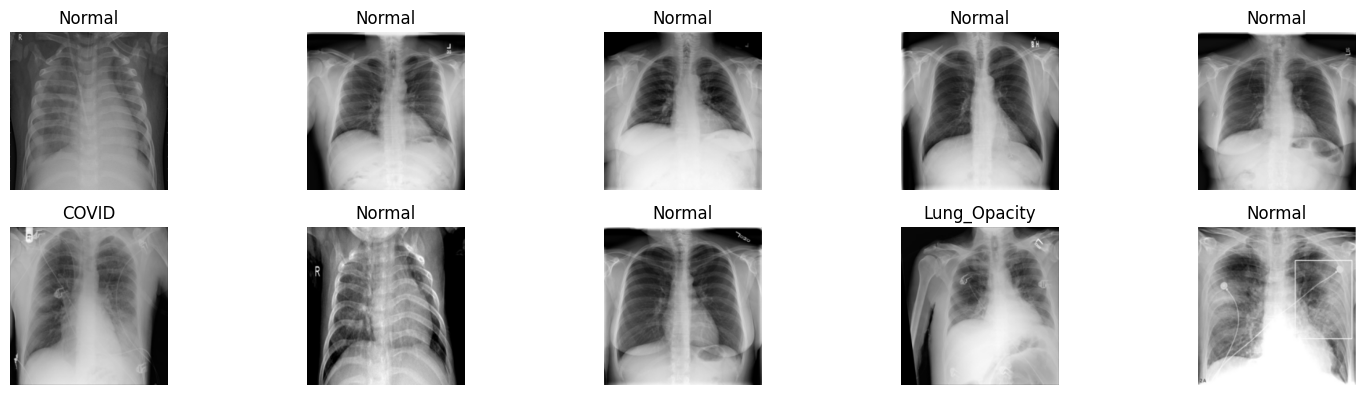

In [23]:
for images, labels in dataset.take (1):
  plt.figure(figsize=(15, 6))
  for i in range(10):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names [class_label_idx[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

## **Re-create datasets with explicit image size and train/val split**

Use image_dataset_from_directory built-in split to create training and validation datasets (stratified by folder).

Why: splits data into training (80%) and validation (20%) automatically.

In [24]:
import tensorflow as tf

#IMG_SIZE = (256, 256)   # consistent input size
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
SEED = 123          # SEED — reproducibility. Using the same seed ensures the train/val split and shuffling are reproducible.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    parent_folder,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    parent_folder,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)


Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [25]:
train_ds.class_names

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

In [26]:
# Get class names BEFORE prefetching
class_names = train_ds.class_names
print("Class names:", class_names)

Class names: ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


## **Optimize dataset performance (cache, prefetch)**
What They Do (Very Brief)

🔹 cache()
* Stores dataset in memory (RAM) or disk after first load
* Makes later epochs faster
* Uses a lot of RAM

🔹 prefetch()
* Loads next batch while GPU is training current batch
* Reduces GPU idle time
* Uses very little memory

#### **What is tf.data.AUTOTUNE?**
```
AUTOTUNE = tf.data.AUTOTUNE
```
* AUTOTUNE is a special TensorFlow setting that tells TensorFlow:
* “Automatically decide the best number of batches to prepare in advance, based on available system resources.”
* So instead of you manually choosing a number, TensorFlow tunes it dynamically.

**Why Do We Need It?**

During training, two things happen:

1) CPU loads and preprocesses images
2) GPU trains the model

If CPU is slow → GPU waits → wasted time ❌

AUTOTUNE helps avoid this by overlapping these two tasks.

Why: speeds up training by overlapping preprocessing and model execution.
1. AUTOTUNE = tf.data.AUTOTUNE
This line is a shortcut. tf.data.AUTOTUNE is a special value that tells the TensorFlow library: "Automatically determine the best buffer size for me." \
Instead of you having to guess a specific number (like 10 or 100), TensorFlow will dynamically adjust the size to maximize performance based on your computer's resources.

2. train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
This line takes your training dataset (train_ds) and applies two main performance boosts: \
.cache():
The Problem: Loading data (e.g., from images on a hard drive) can be slow. If you go through the data once, then want to go through it a second time (for a new training "epoch"), you have to load everything from scratch again. \
The Solution: .cache() tells the system: "The first time you load the data, save it in memory (RAM) or a temporary file."
The Result: Subsequent passes through the same data are lightning fast because the data is read from fast memory instead of a slow hard drive. \
.prefetch(buffer_size=AUTOTUNE):
The Problem: A typical training process looks like a relay race: the CPU prepares data, and the GPU trains the model. Often, the GPU finishes its current task and has to wait idle for the CPU to prepare the next batch of data. \
The Solution: .prefetch() tells the system: "While the GPU is busy training the model with the current batch of data, the CPU should go ahead and prepare the next batch in the background." \
The Result: This clever trick ensures that when the GPU finishes its task, the next batch is already waiting and ready to go, minimizing idle time. AUTOTUNE makes sure the right amount of data is pre-loaded. \
3. val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
This line does the exact same thing as the previous one, but for your validation dataset (val_ds), ensuring that the process of checking your model's performance is also fast and efficient.


In [27]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## **Data augmentation (on the fly)**

Use tf.keras.layers augmentation so augmented images are used at training time only. \
Why: increases robustness and effective dataset size.

1. layers.RandomFlip("horizontal")
What it does: Randomly flips the image horizontally (left becomes right, and right becomes left) about 50% of the time. \
Example: A picture of a dog facing right might be presented to the model as a picture of the dog facing left.

2. layers.RandomRotation(0.08) What it does: Randomly rotates the image slightly within a specified range. \
The 0.08 value: This number is a factor representing how much of a full circle the rotation can be (it's often expressed as a fraction of \(2\pi \) radians, or maximum 8% of 360 degrees). It introduces small tilts.

3. layers.RandomZoom(0.08)
What it does: Randomly zooms the image in or out slightly. \
The 0.08 value: The image can be randomly zoomed by up to 8% (either making the subject look slightly closer or slightly further away).

4. layers.RandomTranslation(0.06, 0.06)
What it does: Randomly shifts the image horizontally and vertically within the frame. \
The (0.06, 0.06) values: The image can move up to 6% horizontally and up to 6% vertically from its original center position. This helps the model learn that the object doesn't always appear in the absolute center of the photograph.


In [28]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.06, 0.06),
])

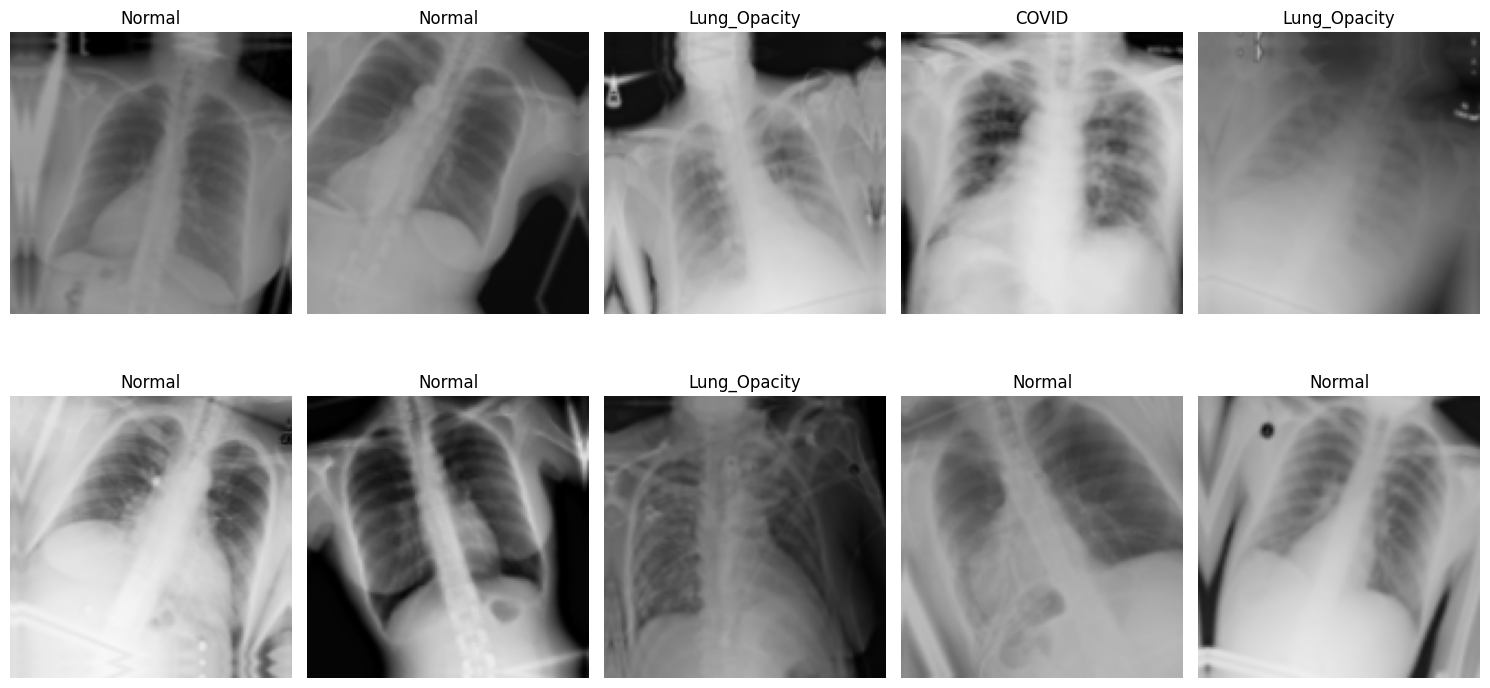

In [29]:
# --- Visualization Code ---

# 1. Take one batch of original images and labels from the training dataset
# Note: The .cache().prefetch() setup is already active on train_ds
for images, labels in train_ds.take(1):
    # 'images' is a batch tensor (e.g., shape (32, 256, 256, 3))
    # 'labels' is a batch of one-hot encoded labels

    plt.figure(figsize=(15, 8))
    # Display the first 10 images from the batch after applying augmentation
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)

        # Apply the augmentation layer to a single image at a time
        # We need tf.expand_dims to make a single image look like a batch of 1 image
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))

        # Convert the tensor to a numpy array of uint8 for plotting
        plt.imshow(augmented_image[0].numpy().astype("uint8"))

        # Get the corresponding class label index (argmax finds the index of the '1' in the one-hot vector)
        class_label_idx = np.argmax(labels[i])
        plt.title(class_names[class_label_idx])

        plt.axis("off")

    plt.tight_layout()
    plt.show()


## **Build a transfer learning model (EfficientNetB0 example)**
Use a pretrained CNN and fine-tune. Transfer learning usually gives much better results quickly.


EfficientNetB0: You choose a state-of-the-art model architecture known as EfficientNetB0. It's a very efficient model developed by Google that's good at seeing shapes, edges, and textures in images.
weights='imagenet': You load the model with weights it already learned from a massive general image database called ImageNet. This gives it a head start.
include_top=False: You cut off the final classification layers of the original model, keeping only the "feature extraction" part (the brain that sees general patterns).
base_model.trainable = False: You "freeze" this brain. You tell the model, "Don't change these existing weights; they are already good. We only want to train our new layers."

Why: EfficientNetB0 is a good balance of speed and accuracy. Freezing base speeds initial training and avoids overfitting.

In [31]:
from tensorflow.keras import layers, models

# Step 3: Base Model
base_model = tf.keras.applications.EfficientNetB0( weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,) )
base_model.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


This code links all the steps together in a Sequential pipeline:

data_augmentation	 Augments: Randomly tweaks input images (flips, rotates) only during training to increase robustness. \
layers.Lambda(...)	 Prepares: Formats the pixel values of the image exactly how the EfficientNet model expects them (standardizing the input data).

base_model	 Extracts Features: The frozen EfficientNet scans the image and pulls out important visual features (edges, shapes, opacities in X-rays).

GlobalAveragePooling2D()	Summarizes: It takes all the feature data the base model found and condenses it into a single, flat list of numbers.

Dropout(0.4)	Prevents Overfitting: Randomly turns off 40% of the connections during training to stop the model from memorizing the exact training examples.

Dense(128, activation='relu') Learns X-ray Patterns: A new, trainable layer where the model starts learning which features (from the previous step) specifically indicate COVID, Normal, etc.

Dropout(0.2)	Prevents Overfitting: Another smaller dropout layer for safety.

Dense(..., activation='softmax') Classifies: The final output layer. It predicts the probability of the image belonging to each of your 4 classes (COVID, Normal, etc.).

In [32]:
# Step 4: Build Model
model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Lambda(tf.keras.applications.efficientnet.preprocess_input))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(class_names), activation='softmax'))

In [33]:
# Calling model.summary() prints a useful, detailed text description of your entire neural network architecture in a table format.
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (1, 128, 128, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (1, 128, 128, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (1, 4, 4, 1280)        │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (1, 1280)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (1, 1280)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 128)               │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (1, 128)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 4)                 │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

1. optimizer='adam'
The optimizer determines how the model's weights are updated based on the estimated loss. It is the algorithm that drives the learning process by adjusting the parameters to minimize the loss function.

'adam' (Adaptive Moment Estimation): This is a very popular and robust optimization algorithm. It is generally a good default choice because it efficiently handles different gradients for different parameters and often converges quickly.

2. loss='categorical_crossentropy'
The loss function (or objective function) quantifies how well the model is performing by measuring the difference between the model's predictions and the actual true labels. The goal of the training process is to minimize this value.

'categorical_crossentropy': This specific loss function is used when dealing with multi-class classification problems where the target labels are provided in a one-hot encoded format (e.g., [1, 0, 0] instead of just 0).

Note: If your labels were integers (e.g., 0, 1, 2), you would use sparse_categorical_crossentropy instead.

3. metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
Metrics are used to monitor the training and testing steps. Unlike the loss function (which is used by the optimizer to update weights), metrics are purely for human-readable evaluation of the model's performance and are not directly used in the optimization process.

'accuracy': This is a common metric that calculates the frequency with which predictions match the true labels (i.e., the percentage of correct predictions).

tf.keras.metrics.AUC(name='auc'): AUC stands for Area Under the Receiver Operating Characteristic (ROC) curve. It is a useful performance metric for classification, particularly when dealing with imbalanced datasets. It measures the model's ability to distinguish between classes at various classification thresholds.





In [34]:
# Step 5: Compile
model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

## **Train the model**
What: Trains model for 10 epochs, evaluating on validation data each epoch. Returns history with loss/metrics logs.

Why: Basic training loop. epochs=10 is a starting point — real training usually uses more epochs with early stopping.

In [35]:
# Step 6: Train
history = model.fit( train_ds, validation_data=val_ds, epochs=10 )

Epoch 1/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 75s 57ms/step - accuracy: 0.7188 - auc: 0.9093 - loss: 0.7161 - val_accuracy: 0.7900 - val_auc: 0.9471 - val_loss: 0.5596
Epoch 2/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step - accuracy: 0.7856 - auc: 0.9465 - loss: 0.5492 - val_accuracy: 0.8216 - val_auc: 0.9581 - val_loss: 0.4905
Epoch 3/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.7951 - auc: 0.9504 - loss: 0.5279 - val_accuracy: 0.8216 - val_auc: 0.9572 - val_loss: 0.4896
Epoch 4/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 26s 24ms/step - accuracy: 0.8054 - auc: 0.9544 - loss: 0.5052 - val_accuracy: 0.8216 - val_auc: 0.9601 - val_loss: 0.4707
Epoch 5/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.8059 - auc: 0.9542 - loss: 0.5055 - val_accuracy: 0.8195 - val_auc: 0.9597 - val_loss: 0.4765
Epoch 6/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.8107 - auc: 0.9564 - loss: 0.4923 - val_accuracy: 0.8297 - val_auc: 0.9637 - val_loss: 0.4486
Epoch 7/10
1059/

## **Evaluate and metrics (confusion matrix + classification report)**

Get predictions on validation set and compute confusion matrix / precision / recall:

In [36]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.concatenate([y.numpy() for x,y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_true, y_pred, target_names=class_names))
print(confusion_matrix(y_true, y_pred))

265/265 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
                 precision    recall  f1-score   support

          COVID       0.65      0.79      0.71       678
   Lung_Opacity       0.81      0.81      0.81      1196
         Normal       0.88      0.83      0.86      2061
Viral Pneumonia       0.93      0.89      0.91       298

       accuracy                           0.82      4233
      macro avg       0.82      0.83      0.82      4233
   weighted avg       0.83      0.82      0.82      4233

[[ 538   51   77   12]
 [ 116  965  113    2]
 [ 180  169 1705    7]
 [   0    1   32  265]]


## **visualize the training performance (loss and accuracy curves).**
These plots help you understand how well your model is learning, whether it’s overfitting, underfitting, or improving properly.

Each of these keys contains a list of metric values for every epoch:

'loss' → Training loss per epoch

'val_loss' → Validation loss per epoch

'accuracy' → Training accuracy per epoch

'val_accuracy' → Validation accuracy per epoch

In [ ]:
import matplotlib.pyplot as plt
history.history.keys()


dict_keys(['accuracy', 'auc', 'loss', 'val_accuracy', 'val_auc', 'val_loss'])

#### Plot Loss Curve
Why:

Loss tells how well the model is minimizing prediction errors.

A steady decrease = good learning.

If training loss ↓ but validation loss ↑, it means overfitting (the model memorizes training data but doesn’t generalize).

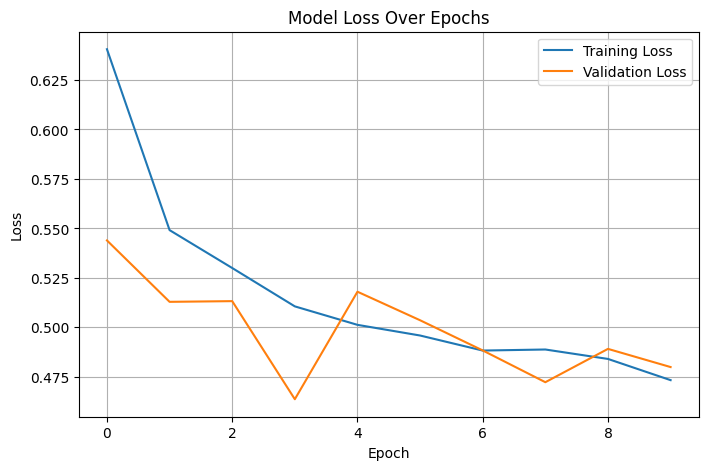

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


#### **Plot Accuracy Curve**
Why:

Shows how accurate the model’s predictions are.

Ideally both training and validation accuracy increase together and stabilize near the same value.

If training accuracy → 99% but validation accuracy stays low (e.g. 70%), you’re overfitting.

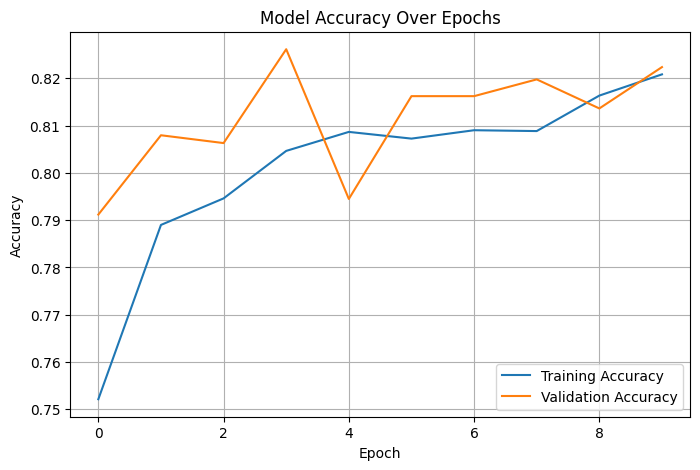

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


#### Plot AUC Curve (Model’s Confidence)
AUC (Area Under Curve) measures how well your model distinguishes between classes.

Closer to 1 → better discrimination (perfect classification).

Useful especially for imbalanced medical datasets like COVID vs Normal.

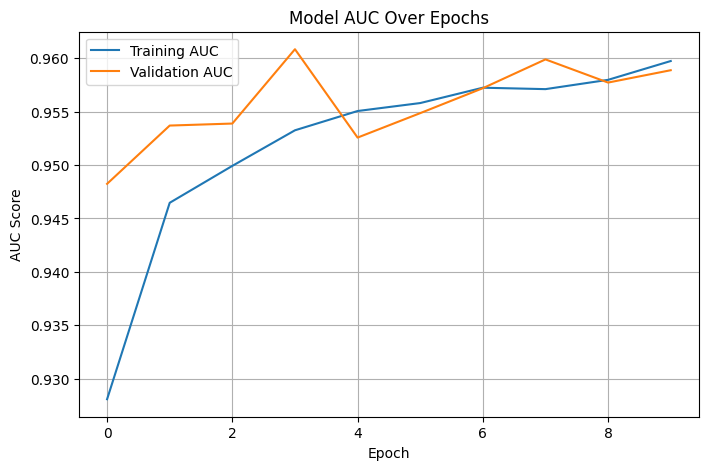

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['auc'], label='Training AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend()
plt.grid(True)
plt.show()


## Plot confusion matrix (simple):
Why: accuracy is not enough—confusion matrix and per-class precision/recall show if model confuses COVID with other pneumonia

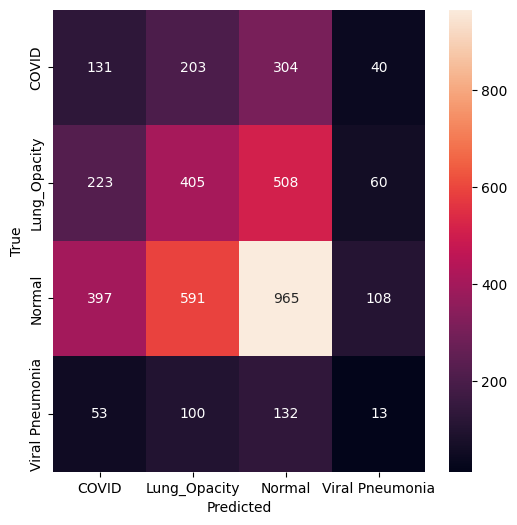

In [ ]:
import seaborn as sns
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_ds.class_names, yticklabels=val_ds.class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()


## Save and load model

Save best model (ModelCheckpoint already created best_model.h5), or save a TF SavedModel:

In [ ]:
#model.save('/content/drive/MyDrive/covid_xray_model')  # to Drive
# later load
# loaded = tf.keras.models.load_model('/content/drive/MyDrive/covid_xray_model')

## **Fine-tuning**

In [46]:
from tensorflow.keras import layers, models

base_model = tf.keras.applications.EfficientNetB0( weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,) )
base_model.trainable = True

for layer in base_model.layers[:-20]:
    layer.trainable = False


model = models.Sequential()
model.add(data_augmentation)
model.add(layers.Lambda(tf.keras.applications.efficientnet.preprocess_input))
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(len(class_names), activation='softmax'))

In [47]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',  # or sparse_categorical_crossentropy
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [48]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
]

In [49]:
history_fine = model.fit( train_ds, validation_data=val_ds, epochs=15, callbacks=[callbacks])

Epoch 1/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 47s 32ms/step - accuracy: 0.4711 - auc_2: 0.7185 - loss: 1.2044 - val_accuracy: 0.7196 - val_auc_2: 0.9105 - val_loss: 0.7618
Epoch 2/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 32s 30ms/step - accuracy: 0.6876 - auc_2: 0.8889 - loss: 0.8222 - val_accuracy: 0.7822 - val_auc_2: 0.9387 - val_loss: 0.6361
Epoch 3/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.7382 - auc_2: 0.9186 - loss: 0.6965 - val_accuracy: 0.8056 - val_auc_2: 0.9477 - val_loss: 0.5800
Epoch 4/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.7652 - auc_2: 0.9343 - loss: 0.6212 - val_accuracy: 0.8141 - val_auc_2: 0.9521 - val_loss: 0.5468
Epoch 5/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.7832 - auc_2: 0.9409 - loss: 0.5840 - val_accuracy: 0.8155 - val_auc_2: 0.9553 - val_loss: 0.5191
Epoch 6/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - accuracy: 0.7925 - auc_2: 0.9470 - loss: 0.5508 - val_accuracy: 0.8146 - val_auc_2: 0.9566 - val_loss:

In [67]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.concatenate([y.numpy() for x,y in val_ds], axis=0)
y_true = np.argmax(y_true, axis=1)
y_pred_probs = model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_true, y_pred, target_names=class_names))
print(confusion_matrix(y_true, y_pred))

265/265 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step
                 precision    recall  f1-score   support

          COVID       0.63      0.83      0.72       678
   Lung_Opacity       0.83      0.80      0.81      1196
         Normal       0.90      0.83      0.87      2061
Viral Pneumonia       0.93      0.89      0.91       298

       accuracy                           0.83      4233
      macro avg       0.82      0.84      0.83      4233
   weighted avg       0.84      0.83      0.83      4233

[[ 563   46   58   11]
 [ 135  958  101    2]
 [ 189  150 1716    6]
 [   2    1   29  266]]


## Load & prepare the image

In [63]:
import os
os.listdir('/content')

['.config',
 'COVID-19_Radiography_Dataset',
 'Screenshot 2025-11-01 192218.png',
 'covid19-radiography-database.zip',
 'sample_data']

In [64]:
img_path = "/content/Screenshot 2025-11-01 192218.png"

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted class: Lung_Opacity
Confidence: 0.946124255657196


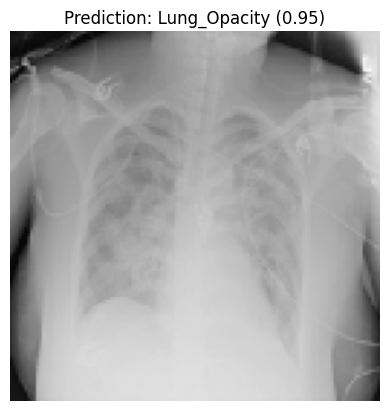

In [66]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

img_path = "/content/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-10.png"

# Load image
img = tf.keras.utils.load_img(
    img_path,
    target_size=IMG_SIZE
)

# Convert to array
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)  # (1, H, W, 3)

# Predict
predictions = model.predict(img_array)
predicted_class = tf.argmax(predictions, axis=1)[0]
confidence = tf.reduce_max(predictions)

# Show result
plt.imshow(img)
plt.title(f"Prediction: {class_names[predicted_class]} ({confidence:.2f})")
plt.axis("off")

print("Predicted class:", class_names[predicted_class])
print("Confidence:", float(confidence))

In [69]:
model.save("/content/covid-19_model.h5")


In [71]:
model.save("/content/covid_19_model.keras")